In [1]:
import zipfile
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Extracting zip files
with zipfile.ZipFile("font_patch.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
print("font_patch.zip extracted successfully.")

with zipfile.ZipFile("sample.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
print("sample.zip extracted successfully.")

font_patch.zip extracted successfully.
sample.zip extracted successfully.


In [3]:
# Custom Dataset for handling image data
class FontPatchDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')  # Grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Image preprocessing functions
def pil_image(img_path):
    pil_im = Image.open(img_path).convert('L')
    return pil_im.resize((105, 105))

def noise_image(pil_im):
    img_array = np.asarray(pil_im)
    noisy_img = img_array + np.random.normal(0.0, 5, img_array.shape)  # Add Gaussian noise
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    return Image.fromarray(np.uint8(noisy_img_clipped)).resize((105, 105))

def blur_image(pil_im):
    return pil_im.filter(ImageFilter.GaussianBlur(radius=3)).resize((105, 105))

In [5]:
# Convert label from string to integer
def conv_label(label):
    label_mapping = {
                      'borna': 0,
                      'dana': 1,
                      'delnia': 2,
                      'doran': 3,
                      'hakaza': 4,
                      'hasti': 5,
                      'iransans': 6,
                      'kook': 7,
                      'liana': 8,
                      'melli': 9,
                      'noora': 10,
                      'paradox': 11,
                      'parsa': 12,
                      'pesteh': 13,
                      'potk': 14,
                      'quarantine': 15,
                      'radio': 16,
                      'shoor': 17,
                      'veno': 18,
                      'yekan-bakh': 19

                    }
    return label_mapping.get(label)

In [6]:
# Load image paths and labels
image_paths = sorted([os.path.join(root, name) for root, _, files in os.walk("font_patch/") for name in files])
random.shuffle(image_paths)
labels = [conv_label(os.path.split(os.path.dirname(path))[-1]) for path in image_paths]



In [7]:
# Split data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.25, random_state=42)

In [8]:
# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
    transforms.RandomApply([transforms.Lambda(noise_image)], p=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor(),
])

In [9]:
# Create datasets and dataloaders
train_dataset = FontPatchDataset(train_paths, train_labels, transform=train_transform)
test_dataset = FontPatchDataset(test_paths, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# Define CNN model with correct input size for fc1
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=48)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=24)
        self.bn2 = nn.BatchNorm2d(128)

        self.convT1 = nn.ConvTranspose2d(128, 128, kernel_size=24, stride=2, padding=12)
        self.convT2 = nn.ConvTranspose2d(128, 64, kernel_size=12, stride=2, padding=6)

        # Updated input size for fc1
        self.fc1 = nn.Linear(2304, 4096)  # 6*6*64 = 2304
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 20)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [11]:
# Model, loss function, and optimizer initialization
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)

In [12]:
# Train the model
epochs = 250
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/250], Loss: 2.997074762980143
Epoch [2/250], Loss: 2.9953485329945884
Epoch [3/250], Loss: 2.996675491333008
Epoch [4/250], Loss: 2.99501363436381
Epoch [5/250], Loss: 2.9942406018575034
Epoch [6/250], Loss: 2.993678569793701
Epoch [7/250], Loss: 2.9908430576324463
Epoch [8/250], Loss: 2.9923737049102783
Epoch [9/250], Loss: 2.9909818172454834
Epoch [10/250], Loss: 2.9880871772766113
Epoch [11/250], Loss: 2.990159193674723
Epoch [12/250], Loss: 2.9863289992014566
Epoch [13/250], Loss: 2.98432993888855
Epoch [14/250], Loss: 2.9852046966552734
Epoch [15/250], Loss: 2.98054830233256
Epoch [16/250], Loss: 2.980490207672119
Epoch [17/250], Loss: 2.9772210915883384
Epoch [18/250], Loss: 2.9782461325327554
Epoch [19/250], Loss: 2.9717363516489663
Epoch [20/250], Loss: 2.967818021774292
Epoch [21/250], Loss: 2.9564491907755532
Epoch [22/250], Loss: 2.9454403718312583
Epoch [23/250], Loss: 2.921522617340088
Epoch [24/250], Loss: 2.8729962507883706
Epoch [25/250], Loss: 2.82024192810058

In [13]:
# Save the model weights
torch.save(model.state_dict(), 'model_weights.pth')
print("Model weights saved successfully.")

Model weights saved successfully.


In [14]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

Test Accuracy: 90.00%


In [68]:
# Load an image and test the model
img_path = "/content/sample/doran1.jpg"
img = Image.open(img_path).convert('L')
img = blur_image(img)
img = test_transform(img).unsqueeze(0)  # Add batch dimensionء‌

In [69]:
# Load the model weights for inference
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Set model to evaluation mode

<ipython-input-69-2b7ebc7c052b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(48, 48), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(24, 24), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT1): ConvTranspose2d(128, 128, kernel_size=(24, 24), stride=(2, 2), padding=(12, 12))
  (convT2): ConvTranspose2d(128, 64, kernel_size=(12, 12), stride=(2, 2), padding=(6, 6))
  (fc1): Linear(in_features=2304, out_features=4096, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=20, bias=True)
)

In [70]:
def rev_conv_label(label):
    label_mapping = {
                      0:'borna',
                      1: 'dana',
                      2: 'delnia',
                      3: 'doran',
                      4: 'hakaza',
                      5: 'hasti',
                      6: 'iransans',
                      7: 'kook',
                      8: 'liana',
                      9: 'melli',
                      10: 'noora',
                      11: 'paradox',
                      12: 'parsa',
                      13: 'pesteh',
                      14: 'potk',
                      15: 'quarantine',
                      16: 'radio',
                      17: 'shoor',
                      18: 'veno',
                      19: 'yekan-bakh'
                    }
    return label_mapping.get(label)


In [71]:
# Make a prediction
with torch.no_grad():
    outputs = model(img)
    predicted_probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities

    # Get the top 3 classes and their probabilities
    top3_probabilities, top3_classes = torch.topk(predicted_probabilities, 3)


In [72]:
# Convert the predicted labels to strings and calculate percentages
labels = [rev_conv_label(top3_classes[0][i].item()) for i in range(3)]
percentages = [top3_probabilities[0][i].item() * 100 for i in range(3)]  # Convert to percentages


In [73]:
# Display the image with predicted labels and similarity percentages
img_np = img.numpy().reshape(105, 105) # Shape will be (105, 105)

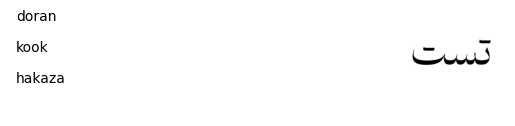

In [74]:
# Display the imageim
img = Image.open(img_path).convert('L')
plt.imshow(img, cmap='gray')

# Display top 3 labels and percentages
for i in range(3):
    plt.text(20, i * 110, f'{labels[i]}', bbox={'facecolor': 'white',
                                                  'edgecolor': 'white',
                                                  'pad': 5})


plt.axis('off')  # Hide axes
plt.show()